In [1]:
from mbmvpa.utils.example_utils import load_example_data
from mbmvpa.preprocessing.preprocess import DataPreprocessor
from mbmvpa.data.loader import BIDSDataLoader
from mbmvpa.models.mvpa_general import MVPA_CV
from mbmvpa.models.elasticnet import MVPA_ElasticNet
from mbmvpa.utils.report import build_elasticnet_report_functions
from pathlib import Path
from time import perf_counter

s = perf_counter()

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
# download example data

root = load_example_data("tom")

data load success! (tom)


## 1. Preprocess data

In [3]:
# Computational model and user-defined functions

dm_model = 'ra_prospect'

def example_adjust(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

def example_filter(row):
    # include all trial data
    return True

def example_latent(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row

In [4]:
# Define & run preprocessor 

preprocessor = DataPreprocessor(bids_layout=root,
                               adjust_function=example_adjust,
                               filter_function=example_filter,
                               latent_function=example_latent,
                               dm_model=dm_model,
                               mask_threshold=2.58,
                               standardize=True,
                               confounds=[],
                               high_pass=1/128,
                               detrend=False,
                               smoothing_fwhm=6, 
                               zoom=(2,2,2),
                               n_core=4)

INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: task name is not designated. find most common task name
INFO: selected task_name is mixedgamblestask
INFO: MB-MVPA is loaded
INFO: 6 file(s) in Original & fMRIPrep.
INFO: individual parameters are loaded


In [5]:
preprocessor.preprocess(overwrite=True)

INFO: start loading & intergrating ROI masks
      gain_uniformity-test_z_FDR_0.01.nii: 7378/902629
      gain_uniformity-test_z_FDR_0.01.nii: 7378/902629
      reward_association-test_z_FDR_0.01.nii: 12969/902629
      loss_association-test_z_FDR_0.01.nii: 783/902629
      loss_uniformity-test_z_FDR_0.01.nii: 9764/902629


[1/2]:   0%|          | 0/2 [00:00<?, ?it/s]

      reward_uniformity-test_z_FDR_0.01.nii: 40410/902629
      integrated mask: 46357/902629
      zoomed (2, 2, 2): 4793/116380
INFO: start processing 6 fMRI. (nii_img/thread)*(n thread)=4*2. 0 image(s) is(are) skipped.


[2/2]: 100%|██████████| 2/2 [00:32<00:00, 16.04s/it]


INFO: fMRI processing is done.
INFO: running hBayesDM
Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl



Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 2
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl


Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'trial', 'subjid', 'run', 'session', 'gamble', 'cert'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'trial', 'subjID', 'run', 'session', 'gamble', 'cert']
************************************
**** Model fitting is complete! ****
************************************


1it [00:00,  7.38it/s]

INFO: indivudal parameters table
  subjID       rho    lambda        tau
0     01  0.515316  1.026708  14.131443
1     02  0.434911  1.603832  13.599799
INFO: start processing 6 events.[task-mixedgamblestask, process-unnamed]


6it [00:00,  7.53it/s]


INFO: events processing is done.


In [6]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: ...m_example/derivatives/fmriprep | Subjects: 2 | Sessions: 0 | Runs: 6
[  MB-MVPA   ] BIDS Layout: ...tom_example/derivatives/mbmvpa | Subjects: 2 | Sessions: 0 | Runs: 6


## 2. load data

In [7]:
loader = BIDSDataLoader(layout=root)
X_dict,y_dict = loader.get_data(subject_wise=True)
voxel_mask = loader.get_voxel_mask()

INFO: retrieving from BIDS Layout: ...tom_example/derivatives/mbmvpa | Subjects: 2 | Sessions: 0 | Runs: 6
      task-None, process-None
INFO: start loading data


INFO: loaded data info. total-4
      subject_01: X(720, 4793), y(720, 1)
      subject_02: X(720, 4793), y(720, 1)
INFO: loaded voxel mask(46, 55, 46)
INFO: loading data done


## 3. Run MVPA model

In [8]:
model = MVPA_ElasticNet(alpha=0.001,
                         n_samples=50000,
                         shuffle=True,
                         max_lambda=100,
                         min_lambda_ratio=1e-4,
                         lambda_search_num=100,
                         n_jobs=16,
                         n_splits=5)

In [9]:
report_function_dict = build_elasticnet_report_functions(voxel_mask,
                                                         confidence_interval=.99,
                                                         n_coef_plot=150,
                                                         task_name='unnamed',
                                                         map_type='z',
                                                         sigma=1
                                                         )

In [10]:
report_path = "example_tom_prospect"
Path(report_path).mkdir(exist_ok=True)

model_cv = MVPA_CV(X_dict,
                    y_dict,
                    model,
                    model_param_dict={},
                    method='5-fold',
                    n_cv_repeat=2,
                    cv_save=True,
                    cv_save_path=report_path,
                    task_name="dd",
                    report_function_dict=report_function_dict)


fold_1:   0%|          | 0/5 [00:00<?, ?it/s]

INFO: start running the experiment. ElasticNet(alpha:0.001)



cv_repeat: 100%|██████████| 2/2 [01:09<00:00, 34.85s/it]


INFO: output statistics
      weights                       10
      pred_train                    10
      y_train                       10
      y_test                        10
      pred_test                     10
      cv_mean_score                 10
      coef_path                     10
      cv_standard_error             10
      lambda_best                   10
      lambda_path                   10
INFO: results are saved at example_tom_prospect/report_ElasticNet(alpha:0.001)_dd_5-fold_2021-04-02-13-51-31/raw_result.


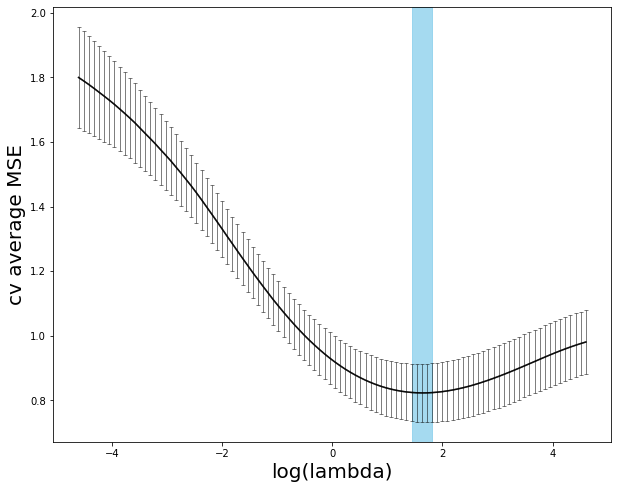

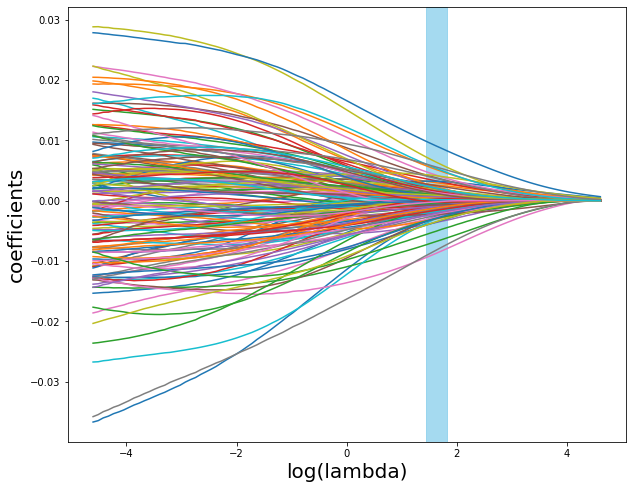

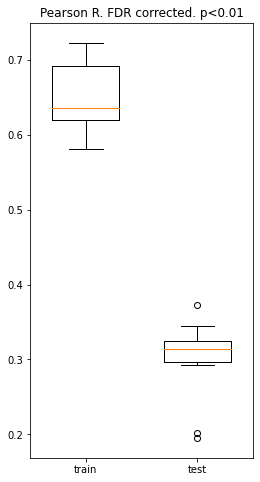

INFO: 3 report(s) is(are) done.
INFO: running done.


In [11]:
reports = model_cv.run()

In [12]:
print(f"INFO: elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

INFO: elapsed time: 4.92 minutes
